In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image

# Custom Dataset Class
class NoisyCleanDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.transform = transform
        self.noisy_images = os.listdir(noisy_dir)

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        noisy_image_name = self.noisy_images[idx]
        noisy_image_path = os.path.join(self.noisy_dir, noisy_image_name)
        clean_image_path = os.path.join(self.clean_dir, noisy_image_name)  # Assuming matching names

        noisy_image = Image.open(noisy_image_path)
        clean_image = Image.open(clean_image_path)

        if self.transform:
            noisy_image = self.transform(noisy_image)
            clean_image = self.transform(clean_image)

        return noisy_image, clean_image

# U-Net Model Definition
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super(UNet, self).__init__()
        
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        
        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.decoder4 = UNet._block(features * 16, features * 8, name="dec4")
        self.decoder3 = UNet._block(features * 8, features * 4, name="dec3")
        self.decoder2 = UNet._block(features * 4, features * 2, name="dec2")
        self.decoder1 = UNet._block(features * 2, features, name="dec1")
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)

        self.conv_last = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv_last(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
        )

# Set directories
noisy_dataset_dir = 'dataset/Noisy_images/train'  # Noisy images path
clean_dataset_dir = 'dataset/Clean_images/train'  # Clean images path

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create dataset
combined_dataset = NoisyCleanDataset(noisy_dataset_dir, clean_dataset_dir, transform=transform)

# Split into train, validation, and test sets (80% train, 10% val, 10% test)
train_size = int(0.8 * len(combined_dataset))
val_size = int(0.1 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

# Print device information
print(f"Training on: {device}")

# Training loop
num_epochs = 20  # You may want to run more epochs with early stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for noisy_images, clean_images in train_loader:
        noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)

        # Forward pass
        outputs = model(noisy_images)
        loss = loss_fn(outputs, clean_images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy_images, clean_images in val_loader:
            noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
            outputs = model(noisy_images)
            loss = loss_fn(outputs, clean_images)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_unet_denoising_model.pth')
        print("Validation loss improved, saving model...")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Testing step
model.eval()
test_loss = 0.0
with torch.no_grad():
    for noisy_images, clean_images in test_loader:
        noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
        outputs = model(noisy_images)
        loss = loss_fn(outputs, clean_images)
        test_loss += loss.item()

print(f'Test Loss: {test_loss/len(test_loader)}')


Training on: cuda


In [40]:
#Denoising on Constant Noise

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image

# Custom Dataset Class
class NoisyCleanDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.transform = transform
        self.noisy_images = os.listdir(noisy_dir)

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        noisy_image_name = self.noisy_images[idx]
        noisy_image_path = os.path.join(self.noisy_dir, noisy_image_name)
        clean_image_path = os.path.join(self.clean_dir, noisy_image_name)  # Assuming matching names

        noisy_image = Image.open(noisy_image_path)
        clean_image = Image.open(clean_image_path)

        if self.transform:
            noisy_image = self.transform(noisy_image)
            clean_image = self.transform(clean_image)

        return noisy_image, clean_image

# DnCNN Model Definition
class DnCNN(nn.Module):
    def __init__(self, depth=11, n_channels=64, image_channels=3, use_bnorm=True):
        super(DnCNN, self).__init__()
        layers = []

        # First layer: Convolution + ReLU
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))

        # Hidden layers: Convolution + BatchNorm + ReLU
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=False))
            if use_bnorm:
                layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))

        # Last layer: Convolution (no activation)
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=3, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise  # Subtract the noise from the input (residual learning)

# Set directories
noisy_dataset_dir = 'Noisy_images'
clean_dataset_dir = 'Clean_images'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create dataset
combined_dataset = NoisyCleanDataset(noisy_dataset_dir, clean_dataset_dir, transform=transform)

# Split into train, validation, and test sets
train_size = int(0.8 * len(combined_dataset))
val_size = int(0.1 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Reduce batch size if needed
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DnCNN(image_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

# Mixed precision scaler
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

# Print device information
print(f"Training on: {device}")

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for noisy_images, clean_images in train_loader:
        noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)

        # Mixed precision training
        with autocast():
            outputs = model(noisy_images)
            loss = loss_fn(outputs, clean_images)

        # Backward pass and optimization
        optimizer.zero_grad()
        scaler.scale(loss).backward()  # Scale the loss
        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update the scaler

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy_images, clean_images in val_loader:
            noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
            outputs = model(noisy_images)
            loss = loss_fn(outputs, clean_images)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_dncnn_denoising_model.pth')
        print("Validation loss improved, saving model...")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Testing step
model.eval()
test_loss = 0.0
with torch.no_grad():
    for noisy_images, clean_images in test_loader:
        noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
        outputs = model(noisy_images)
        loss = loss_fn(outputs, clean_images)
        test_loss += loss.item()

print(f'Test Loss: {test_loss/len(test_loader)}')


C:\Users\bhara\AppData\Local\Temp\ipykernel_1844\4045432965.py:97: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\bhara\AppData\Local\Temp\ipykernel_1844\4045432965.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Training on: cuda
Epoch [1/20], Loss: 0.001222935271063602
Validation Loss: 0.0006134171264928354
Validation loss improved, saving model...
Epoch [2/20], Loss: 0.0005348627789483072
Validation Loss: 0.0004712933541456952
Validation loss improved, saving model...
Epoch [3/20], Loss: 0.0004785154015463131
Validation Loss: 0.00045817418428013363
Validation loss improved, saving model...
Epoch [4/20], Loss: 0.0004561777671681799
Validation Loss: 0.000422690263550003
Validation loss improved, saving model...
Epoch [5/20], Loss: 0.0004358338442568185
Validation Loss: 0.00048386917444796107
Epoch [6/20], Loss: 0.00042205549739165245
Validation Loss: 0.0004032493449157364
Validation loss improved, saving model...
Epoch [7/20], Loss: 0.0003986938732054193
Validation Loss: 0.0003878436410707573
Validation loss improved, saving model...
Epoch [8/20], Loss: 0.0003898876624217556
Validation Loss: 0.0003770714057853099
Validation loss improved, saving model...
Epoch [9/20], Loss: 0.00038151961840930

In [1]:
#Denoising on Random Noise

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image

# Custom Dataset Class
class NoisyCleanDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.transform = transform
        self.noisy_images = os.listdir(noisy_dir)

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        noisy_image_name = self.noisy_images[idx]
        noisy_image_path = os.path.join(self.noisy_dir, noisy_image_name)
        clean_image_path = os.path.join(self.clean_dir, noisy_image_name)  # Assuming matching names

        noisy_image = Image.open(noisy_image_path)
        clean_image = Image.open(clean_image_path)

        if self.transform:
            noisy_image = self.transform(noisy_image)
            clean_image = self.transform(clean_image)

        return noisy_image, clean_image

# DnCNN Model Definition
class DnCNN(nn.Module):
    def __init__(self, depth=11, n_channels=64, image_channels=3, use_bnorm=True):
        super(DnCNN, self).__init__()
        layers = []

        # First layer: Convolution + ReLU
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))

        # Hidden layers: Convolution + BatchNorm + ReLU
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=False))
            if use_bnorm:
                layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))

        # Last layer: Convolution (no activation)
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=3, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise  # Subtract the noise from the input (residual learning)

# Set directories
noisy_dataset_dir = 'Random_Noisy_images'
clean_dataset_dir = 'Clean_images'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create dataset
combined_dataset = NoisyCleanDataset(noisy_dataset_dir, clean_dataset_dir, transform=transform)

# Split into train, validation, and test sets
train_size = int(0.8 * len(combined_dataset))
val_size = int(0.1 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Reduce batch size if needed
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DnCNN(image_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

# Mixed precision scaler
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

# Print device information
print(f"Training on: {device}")

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for noisy_images, clean_images in train_loader:
        noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)

        # Mixed precision training
        with autocast():
            outputs = model(noisy_images)
            loss = loss_fn(outputs, clean_images)

        # Backward pass and optimization
        optimizer.zero_grad()
        scaler.scale(loss).backward()  # Scale the loss
        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update the scaler

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy_images, clean_images in val_loader:
            noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
            outputs = model(noisy_images)
            loss = loss_fn(outputs, clean_images)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_dncnn_denoising_model_1.pth')
        print("Validation loss improved, saving model...")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Testing step
model.eval()
test_loss = 0.0
with torch.no_grad():
    for noisy_images, clean_images in test_loader:
        noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
        outputs = model(noisy_images)
        loss = loss_fn(outputs, clean_images)
        test_loss += loss.item()

print(f'Test Loss: {test_loss/len(test_loader)}')


C:\Users\bhara\AppData\Local\Temp\ipykernel_1500\3984570425.py:97: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\bhara\AppData\Local\Temp\ipykernel_1500\3984570425.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Training on: cuda
Epoch [1/25], Loss: 0.03929414845170139
Validation Loss: 0.03244186410349663
Validation loss improved, saving model...
Epoch [2/25], Loss: 0.030744492521066973
Validation Loss: 0.028918517379212045
Validation loss improved, saving model...
Epoch [3/25], Loss: 0.027692487308950155
Validation Loss: 0.026651067820281905
Validation loss improved, saving model...
Epoch [4/25], Loss: 0.026080085952498205
Validation Loss: 0.025644966657926267
Validation loss improved, saving model...
Epoch [5/25], Loss: 0.024950043759344096
Validation Loss: 0.02613378043730404
Epoch [6/25], Loss: 0.024177204626702073
Validation Loss: 0.024390218309431434
Validation loss improved, saving model...
Epoch [7/25], Loss: 0.0230871524903173
Validation Loss: 0.022712643880605975
Validation loss improved, saving model...
Epoch [8/25], Loss: 0.022650276769063518
Validation Loss: 0.02380830265372713
Epoch [9/25], Loss: 0.022168334148893805
Validation Loss: 0.02382871952499742
Epoch [10/25], Loss: 0.021

In [3]:
# DnCNN Model Definition
class DnCNN(nn.Module):
    def __init__(self, depth=11, n_channels=64, image_channels=3, use_bnorm=True):
        super(DnCNN, self).__init__()
        layers = []

        # First layer: Convolution + ReLU
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))

        # Hidden layers: Convolution + BatchNorm + ReLU
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=False))
            if use_bnorm:
                layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))

        # Last layer: Convolution (no activation)
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=3, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise  # Subtract the noise from the input (residual learning)

C:\Users\bhara\AppData\Local\Temp\ipykernel_35784\2696329404.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_dncnn_denoising_mode

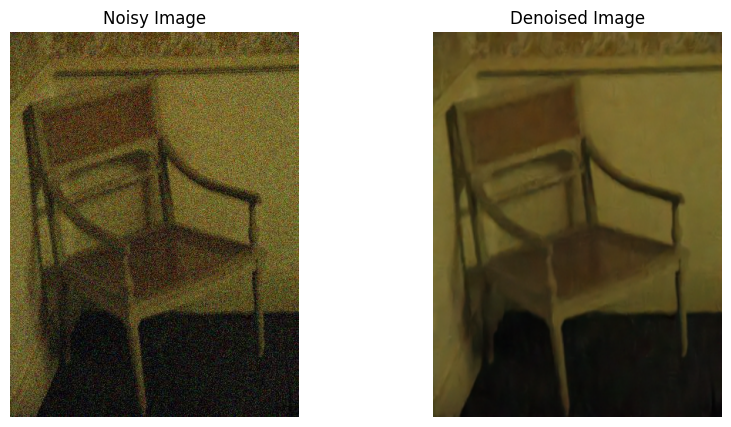

In [6]:
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the best trained model
model = DnCNN(image_channels=3).to(device)
model.load_state_dict(torch.load('best_dncnn_denoising_model.pth'))
model.eval()  # Set the model to evaluation mode

# Set the path for the noisy image you want to test
noisy_image_path = r'C:\Users\bhara\Desktop\AIAss\Denoising\Noisy_images_test\2008_000004.jpg'

# Transform for the test image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load and transform the noisy image
noisy_image = Image.open(noisy_image_path).convert('RGB')  # Ensure it's RGB
noisy_image_tensor = transform(noisy_image).unsqueeze(0).to(device)  # Add batch dimension and send to device

# Get denoised output
with torch.no_grad():
    denoised_image_tensor = model(noisy_image_tensor)

# Convert tensors to images for visualization
denoised_image = denoised_image_tensor.squeeze(0).cpu().clamp(0, 1)  # Remove batch dimension and clamp
denoised_image = transforms.ToPILImage()(denoised_image)  # Convert to PIL image

# Resize denoised image to match noisy image size
denoised_image = denoised_image.resize(noisy_image.size)

# Display the noisy and denoised images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Noisy Image")
plt.imshow(noisy_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Denoised Image")
plt.imshow(denoised_image)
plt.axis("off")

plt.show()  # Show the images


C:\Users\bhara\AppData\Local\Temp\ipykernel_35784\2521825593.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_dncnn_denoising_mode

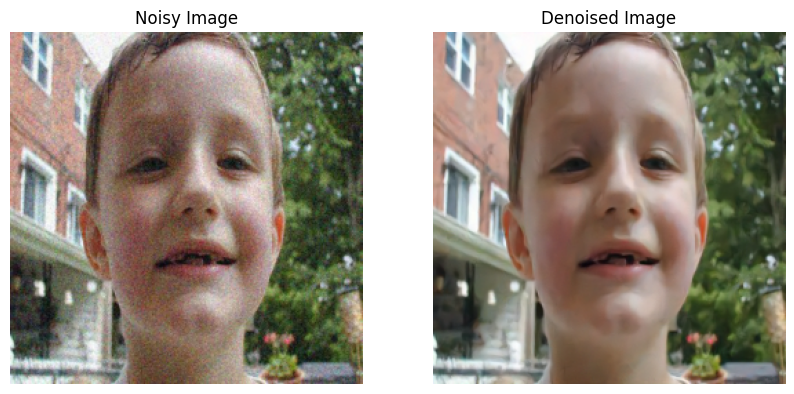

In [9]:
import torch
import torch.nn as nn  # Import nn module
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# DnCNN Model Definition (same as the one used for training)
class DnCNN(nn.Module):
    def __init__(self, depth=11, n_channels=64, image_channels=3, use_bnorm=True):
        super(DnCNN, self).__init__()
        layers = []

        # First layer: Convolution + ReLU
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))

        # Hidden layers: Convolution + BatchNorm + ReLU
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=False))
            if use_bnorm:
                layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))

        # Last layer: Convolution (no activation)
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=3, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise  # Subtract the noise from the input (residual learning)

# Load the best trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DnCNN(image_channels=3).to(device)
model.load_state_dict(torch.load('best_dncnn_denoising_model.pth'))
model.eval()

# Path to your noisy image
noisy_image_path = r'C:\Users\bhara\Desktop\AIAss\Denoising\Noisy_images_test\2008_000010.jpg'

# Define transform (must match the one used during training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load and transform the noisy image
noisy_image = Image.open(noisy_image_path)
noisy_image_tensor = transform(noisy_image).unsqueeze(0).to(device)  # Add batch dimension

# Denoise the image
with torch.no_grad():
    denoised_image_tensor = model(noisy_image_tensor).clamp(0, 1)

# Convert the tensors back to PIL images for display
denoised_image = transforms.ToPILImage()(denoised_image_tensor.squeeze().cpu())  # Remove batch dimension
noisy_image_resized = transforms.ToPILImage()(noisy_image_tensor.squeeze().cpu())  # Resized noisy image for comparison

# Display noisy and denoised images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Noisy Image")
plt.imshow(noisy_image_resized)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Denoised Image")
plt.imshow(denoised_image)
plt.axis("off")

plt.show()


In [8]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# DnCNN Model Definition (same as the one used for training)
class DnCNN(nn.Module):
    def __init__(self, depth=11, n_channels=64, image_channels=3, use_bnorm=True):
        super(DnCNN, self).__init__()
        layers = []

        # First layer: Convolution + ReLU
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))

        # Hidden layers: Convolution + BatchNorm + ReLU
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=False))
            if use_bnorm:
                layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))

        # Last layer: Convolution (no activation)
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=3, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise  # Subtract the noise from the input (residual learning)

# Load the best trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DnCNN(image_channels=3).to(device)
model.load_state_dict(torch.load('best_dncnn_denoising_model.pth'))
model.eval()

# Define transform (must match the one used during training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Function to process all images in a folder and save the denoised images
def denoise_images_in_folder(noisy_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)  # Create output folder if it doesn't exist

    for image_name in os.listdir(noisy_folder):
        noisy_image_path = os.path.join(noisy_folder, image_name)
        
        if os.path.isfile(noisy_image_path):  # Check if it's a file
            try:
                # Load and transform the noisy image
                noisy_image = Image.open(noisy_image_path)
                noisy_image_tensor = transform(noisy_image).unsqueeze(0).to(device)  # Add batch dimension

                # Denoise the image
                with torch.no_grad():
                    denoised_image_tensor = model(noisy_image_tensor).clamp(0, 1)

                # Convert the denoised tensor back to a PIL image
                denoised_image = transforms.ToPILImage()(denoised_image_tensor.squeeze().cpu())  # Remove batch dimension

                # Save the denoised image
                output_image_path = os.path.join(output_folder, image_name)
                denoised_image.save(output_image_path)
                print(f'Saved denoised image: {output_image_path}')
            
            except Exception as e:
                print(f"Error processing {image_name}: {e}")

# Paths to input (noisy images folder) and output (where denoised images will be saved)
noisy_images_folder = r'C:/Users/bhara/Desktop/AIAss/Noisy_images_test'
output_denoised_folder = r'C:/Users/bhara/Desktop/AIAss/Denoised_images_test'

# Process the images
denoise_images_in_folder(noisy_images_folder, output_denoised_folder)


C:\Users\bhara\AppData\Local\Temp\ipykernel_6072\733952104.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_dncnn_denoising_model.

Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images\2007_000027.jpg
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images\2007_000032.jpg
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images\2007_000033.jpg
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images\2007_000039.jpg
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images\2007_000042.jpg
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images\2007_000061.jpg
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images\2007_000063.jpg
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images\2007_000068.jpg
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images\2007_000121.jpg
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images\2007_000123.jpg
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images\2007_000129.jpg
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images\2007_000170.jpg
Save

In [13]:
import os
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# DnCNN Model Definition (same as the one used for training)
class DnCNN(nn.Module):
    def __init__(self, depth=11, n_channels=64, image_channels=3, use_bnorm=True):
        super(DnCNN, self).__init__()
        layers = []

        # First layer: Convolution + ReLU
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))

        # Hidden layers: Convolution + BatchNorm + ReLU
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=False))
            if use_bnorm:
                layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))

        # Last layer: Convolution (no activation)
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=3, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise  # Subtract the noise from the input (residual learning)

# Load the best trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DnCNN(image_channels=3).to(device)
model.load_state_dict(torch.load('best_dncnn_denoising_model.pth'))
model.eval()

# Define transform (must match the one used during training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Function to process all images in a folder, denoise them, and save the denoised images along with noise parameters
def denoise_images_in_folder(noisy_folder, output_folder, noise_params_folder):
    os.makedirs(output_folder, exist_ok=True)  # Create output folder if it doesn't exist
    os.makedirs(noise_params_folder, exist_ok=True)  # Create noise parameters folder if it doesn't exist

    for image_name in os.listdir(noisy_folder):
        noisy_image_path = os.path.join(noisy_folder, image_name)
        
        if os.path.isfile(noisy_image_path):  # Check if it's a file
            try:
                # Load and transform the noisy image
                noisy_image = Image.open(noisy_image_path)
                original_size = noisy_image.size  # Store the original size for later use
                noisy_image_tensor = transform(noisy_image).unsqueeze(0).to(device)  # Add batch dimension

                # Denoise the image
                with torch.no_grad():
                    denoised_image_tensor = model(noisy_image_tensor).clamp(0, 1)

                # Convert the denoised tensor back to a PIL image
                denoised_image = transforms.ToPILImage()(denoised_image_tensor.squeeze().cpu())  # Remove batch dimension

                # Resize the denoised image back to original size for noise calculation
                denoised_image = denoised_image.resize(original_size, Image.BICUBIC)
                denoised_image_np = np.array(denoised_image) / 255.0  # Convert to [0, 1] range
                noisy_image_np = np.array(noisy_image) / 255.0  # Convert to [0, 1] range

                # Calculate noise parameters (standard deviation)
                noise = noisy_image_np - denoised_image_np  # Estimate noise
                noise_std = np.std(noise)  # Calculate standard deviation of the noise

                # Save the denoised image
                output_image_path = os.path.join(output_folder, image_name)
                denoised_image.save(output_image_path)

                # Save the noise parameter in a text file
                noise_params_path = os.path.join(noise_params_folder, f'{os.path.splitext(image_name)[0]}_noise_params.txt')
                with open(noise_params_path, 'w') as f:
                    f.write(f'Noise Standard Deviation: {noise_std:.4f}\n')
                
                print(f'Saved denoised image: {output_image_path} | Noise Std: {noise_std:.4f}')
            
            except Exception as e:
                print(f"Error processing {image_name}: {e}")

# Paths to input (noisy images folder), output (where denoised images will be saved), and noise parameters folder
noisy_images_folder = r'C:/Users/bhara/Desktop/AIAss/Noisy_images_test'
output_denoised_folder = r'C:/Users/bhara/Desktop/AIAss/Denoised_images_test'
output_noise_params_folder = r'C:/Users/bhara/Desktop/AIAss/Noise_Parameters_test'

# Process the images
denoise_images_in_folder(noisy_images_folder, output_denoised_folder, output_noise_params_folder)


C:\Users\bhara\AppData\Local\Temp\ipykernel_6072\1145416278.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_dncnn_denoising_model

Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images_test\2008_000001.jpg | Noise Std: 0.0848
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images_test\2008_000004.jpg | Noise Std: 0.0670
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images_test\2008_000005.jpg | Noise Std: 0.0741
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images_test\2008_000006.jpg | Noise Std: 0.0605
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images_test\2008_000010.jpg | Noise Std: 0.0704
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images_test\2008_000011.jpg | Noise Std: 0.0806
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images_test\2008_000012.jpg | Noise Std: 0.0717
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images_test\2008_000013.jpg | Noise Std: 0.1225
Saved denoised image: C:/Users/bhara/Desktop/AIAss/Denoised_images_test\2008_000014.jpg | Noise Std: 0.0954
Saved denoised image: C:/Use

In [39]:
import os
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# DnCNN Model Definition (same as the one used for training)
class DnCNN(nn.Module):
    def __init__(self, depth=11, n_channels=64, image_channels=3, use_bnorm=True):
        super(DnCNN, self).__init__()
        layers = []

        # First layer: Convolution + ReLU
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))

        # Hidden layers: Convolution + BatchNorm + ReLU
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding=1, bias=False))
            if use_bnorm:
                layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))

        # Last layer: Convolution (no activation)
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=3, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise  # Subtract the noise from the input (residual learning)

# Load the best trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DnCNN(image_channels=3).to(device)
model.load_state_dict(torch.load('best_dncnn_denoising_model.pth'))
model.eval()

# Define transform (must match the one used during training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Function to process all images in a folder, denoise them, and save the denoised images along with noise parameters
def denoise_images_in_folder(noisy_folder, output_folder, noise_params_folder):
    os.makedirs(output_folder, exist_ok=True)  # Create output folder if it doesn't exist
    os.makedirs(noise_params_folder, exist_ok=True)  # Create noise parameters folder if it doesn't exist

    for image_name in os.listdir(noisy_folder):
        noisy_image_path = os.path.join(noisy_folder, image_name)
        
        if os.path.isfile(noisy_image_path):  # Check if it's a file
            try:
                # Load and transform the noisy image
                noisy_image = Image.open(noisy_image_path)
                original_size = noisy_image.size  # Store the original size for later use
                noisy_image_tensor = transform(noisy_image).unsqueeze(0).to(device)  # Add batch dimension

                # Denoise the image
                with torch.no_grad():
                    denoised_image_tensor = model(noisy_image_tensor).clamp(0, 1)

                # Convert the denoised tensor back to a PIL image
                denoised_image = transforms.ToPILImage()(denoised_image_tensor.squeeze().cpu())  # Remove batch dimension

                # Resize the denoised image back to original size for noise calculation
                denoised_image = denoised_image.resize(original_size, Image.BICUBIC)
                denoised_image_np = np.array(denoised_image) / 255.0  # Convert to [0, 1] range
                noisy_image_np = np.array(noisy_image) / 255.0  # Convert to [0, 1] range

                # Calculate noise parameters (standard deviation)
                noise = noisy_image_np - denoised_image_np  # Estimate noise
                noise_std = np.std(noise)  # Calculate standard deviation of the noise

                # Save the denoised image
                output_image_path = os.path.join(output_folder, image_name)
                denoised_image.save(output_image_path)

                # Save the noise parameter in a text file
                noise_params_path = os.path.join(noise_params_folder, f'{os.path.splitext(image_name)[0]}_noise_params.txt')
                with open(noise_params_path, 'w') as f:
                    f.write(f'Noise Standard Deviation: {noise_std:.4f}\n')
                
                print(f'Saved denoised image: {output_image_path} | Noise Std: {noise_std:.4f}')
            
            except Exception as e:
                print(f"Error processing {image_name}: {e}")

# Paths to input (noisy images folder), output (where denoised images will be saved), and noise parameters folder
noisy_images_folder = r'C:\Users\bhara\Desktop\AIAss\Denoising\Random_Noisy_images'
output_denoised_folder = r'C:\Users\bhara\Desktop\AIAss\Denoising\Denoised_images_test_2'
output_noise_params_folder = r'C:\Users\bhara\Desktop\AIAss\Denoising\Noise_Parameters_test_2'

# Process the images
denoise_images_in_folder(noisy_images_folder, output_denoised_folder, output_noise_params_folder)


C:\Users\bhara\AppData\Local\Temp\ipykernel_41164\618143153.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_dncnn_denoising_model

Saved denoised image: C:\Users\bhara\Desktop\AIAss\Denoising\Denoised_images_test_2\2007_000027.jpg | Noise Std: 0.0674
Saved denoised image: C:\Users\bhara\Desktop\AIAss\Denoising\Denoised_images_test_2\2007_000032.jpg | Noise Std: 0.0800
Saved denoised image: C:\Users\bhara\Desktop\AIAss\Denoising\Denoised_images_test_2\2007_000033.jpg | Noise Std: 0.0736
Saved denoised image: C:\Users\bhara\Desktop\AIAss\Denoising\Denoised_images_test_2\2007_000039.jpg | Noise Std: 0.1023
Saved denoised image: C:\Users\bhara\Desktop\AIAss\Denoising\Denoised_images_test_2\2007_000042.jpg | Noise Std: 0.0687
Saved denoised image: C:\Users\bhara\Desktop\AIAss\Denoising\Denoised_images_test_2\2007_000061.jpg | Noise Std: 0.0563
Saved denoised image: C:\Users\bhara\Desktop\AIAss\Denoising\Denoised_images_test_2\2007_000063.jpg | Noise Std: 0.0739
Saved denoised image: C:\Users\bhara\Desktop\AIAss\Denoising\Denoised_images_test_2\2007_000068.jpg | Noise Std: 0.0948
Saved denoised image: C:\Users\bhara\Des